## Import Packages

In [1]:
# !pip install scanpy
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(42)

/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [2]:
# Import Raw Data
adata = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/published_reference_material/h5ad_files/2_GSE147319_adata_raw.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 28456 × 27998
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'sample'
    var: 'mean', 'frac_zeros'


## Data Cleaning
1. Removed Previous researchers work to start from scratch

In [3]:
# Specify the columns to remove
columns_to_remove = ['mean', 'frac_zeros']  # Replace with actual column names

# Remove specified columns
adata.var = adata.var.drop(columns=columns_to_remove)
adata.var.index.name = None
adata.var.head()

""
Xkr4
Gm1992
Gm37381
Rp1
Rp1-1


In [4]:
# Specify the columns to remove
columns_to_remove = ['percent_mito', 'percent_ribo', 'n_counts', 'n_genes']  # Replace with actual column names

# Remove specified columns
adata.obs = adata.obs.drop(columns=columns_to_remove)
adata.obs.index.name = None

# Add a new column representing diet
adata.obs['Diet'] = adata.obs['sample'].str[:-2]

# Capitalise the sample column
adata.obs.rename(columns={'sample': 'Sample'}, inplace=True)

# Correct the naming of the diets
adata.obs['Diet'] = adata.obs['Diet'].replace({'HFD': 'HFHSD'})

# Set the Diet colours for plotting
adata.uns['Diet_colors'] = ['grey', 'red']

adata.obs

,Sample,Diet
AAACCTGAGAGTAAGG-1-CD_1,CD_1,CD
AAACCTGAGGTGATTA-1-CD_1,CD_1,CD
AAACCTGCAAGTAGTA-1-CD_1,CD_1,CD
AAACCTGCACACCGAC-1-CD_1,CD_1,CD
AAACCTGGTACACCGC-1-CD_1,CD_1,CD
...,...,...
TTTGTCAGTCGTTGTA-1-HFD_3,HFD_3,HFHSD
TTTGTCAGTCTTGATG-1-HFD_3,HFD_3,HFHSD
TTTGTCATCAAGAAGT-1-HFD_3,HFD_3,HFHSD
TTTGTCATCAGGCCCA-1-HFD_3,HFD_3,HFHSD


In [5]:
adata.uns['Diet_colors']

['grey', 'red']

## Quality Control  
**Description:**  
The scanpy function calculate_qc_metrics() calculates common quality control (QC) metrics. Mitochondrial, ribosomal and hemoglobin genes are defined as shown below.

In [6]:
# mitochondrial genes, "MT-" for human, "mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(pe)]")

In [7]:
print('Number of mitochondrial genes:', adata.var['mt'].sum())
print('Number of ribosomal genes:', adata.var['ribo'].sum())
print('Number of hemoglobin genes:', adata.var['hb'].sum())

Number of mitochondrial genes: 13
Number of ribosomal genes: 113
Number of hemoglobin genes: 11


In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

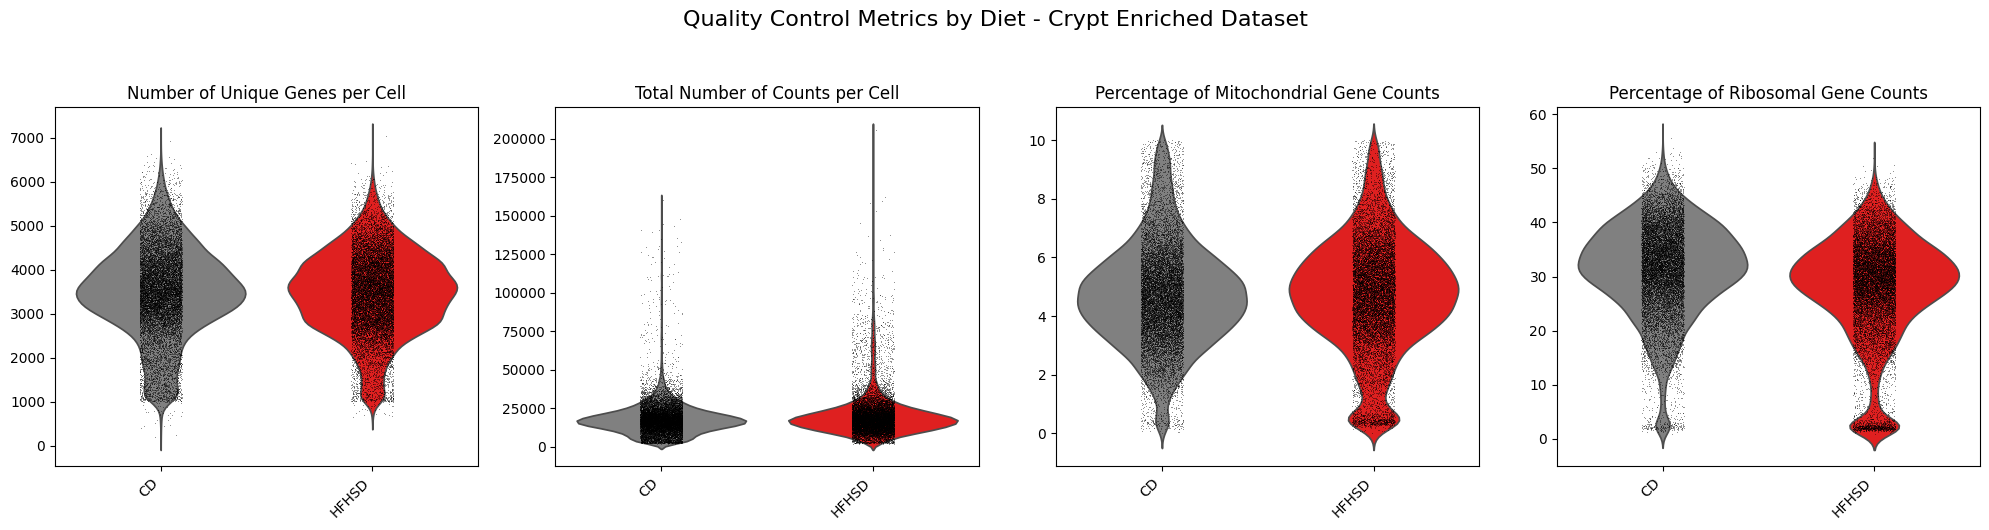

In [9]:
# Plotting violin plots with overlaid scatter plots in one row, grouped by diet
labels = ['Number of Unique Genes per Cell', 'Total Number of Counts per Cell', 'Percentage of Mitochondrial Gene Counts', 'Percentage of Ribosomal Gene Counts']
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Add main title for the whole graph
fig.suptitle('Quality Control Metrics by Diet - Crypt Enriched Dataset', fontsize=16, y=1.05)

for i, (label, key) in enumerate(zip(labels, keys)):
    ax = axes[i]
    
    # Create violin plot, grouped by diet
    sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, legend=False, palette=adata.uns['Diet_colors'])
    
    # Overlay scatter plot, grouped by diet
    sns.stripplot(data=adata.obs, x='Diet', y=key, ax=ax, size=0.4, jitter=True, dodge=False, legend=False, color='black')
    
    # Customize the plot
    ax.set_title(label)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    # Increase the number of y-axis ticks for the second plot (Total Number of Counts per Cell)
    if i == 1:
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    # Rotate x-axis labels for better readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

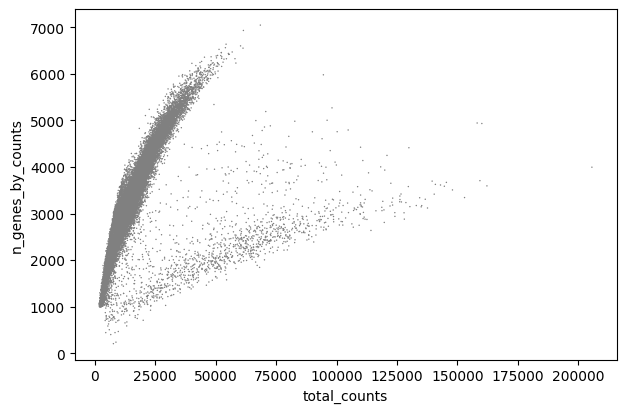

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

## Gene and Cell filtering
1. Remove genes found in less than 10 cells.  
2. Remove cells with less than 200 genes by counts.
3. Remove cells with less than 500 total counts.

In [11]:
# 1. Remove genes found in less than 10 cells.
print('Number of genes:', len(adata.var))
print('Removing genes in less than 10 cells... ⌛')
sc.pp.filter_genes(adata, min_cells = 5)
print('Number of genes:', len(adata.var))

Number of genes: 27998
Removing genes in less than 10 cells... ⌛
Number of genes: 17573


In [12]:
# 2. Remove cells with less than 200 genes by counts.
print('Number of cells:', len(adata.obs))
print('Removing cells with less than 200 genes by counts... ⌛')
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells:', len(adata.obs))

Number of cells: 28456
Removing cells with less than 200 genes by counts... ⌛
Number of cells: 28456


In [13]:
# 2. Remove cells with less than 500 total counts.
print('Number of cells:', len(adata.obs))
print('Removing cells with less than 500 total counts... ⌛')
sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells:', len(adata.obs))

Number of cells: 28456
Removing cells with less than 500 total counts... ⌛
Number of cells: 28456


## Doublet Removal with scrublet
**Description:**  
Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets.

In [14]:
print('Predicting doublets... ⌛')
sc.pp.scrublet(adata, batch_key="Sample") # 2min 11s

Predicting doublets... ⌛


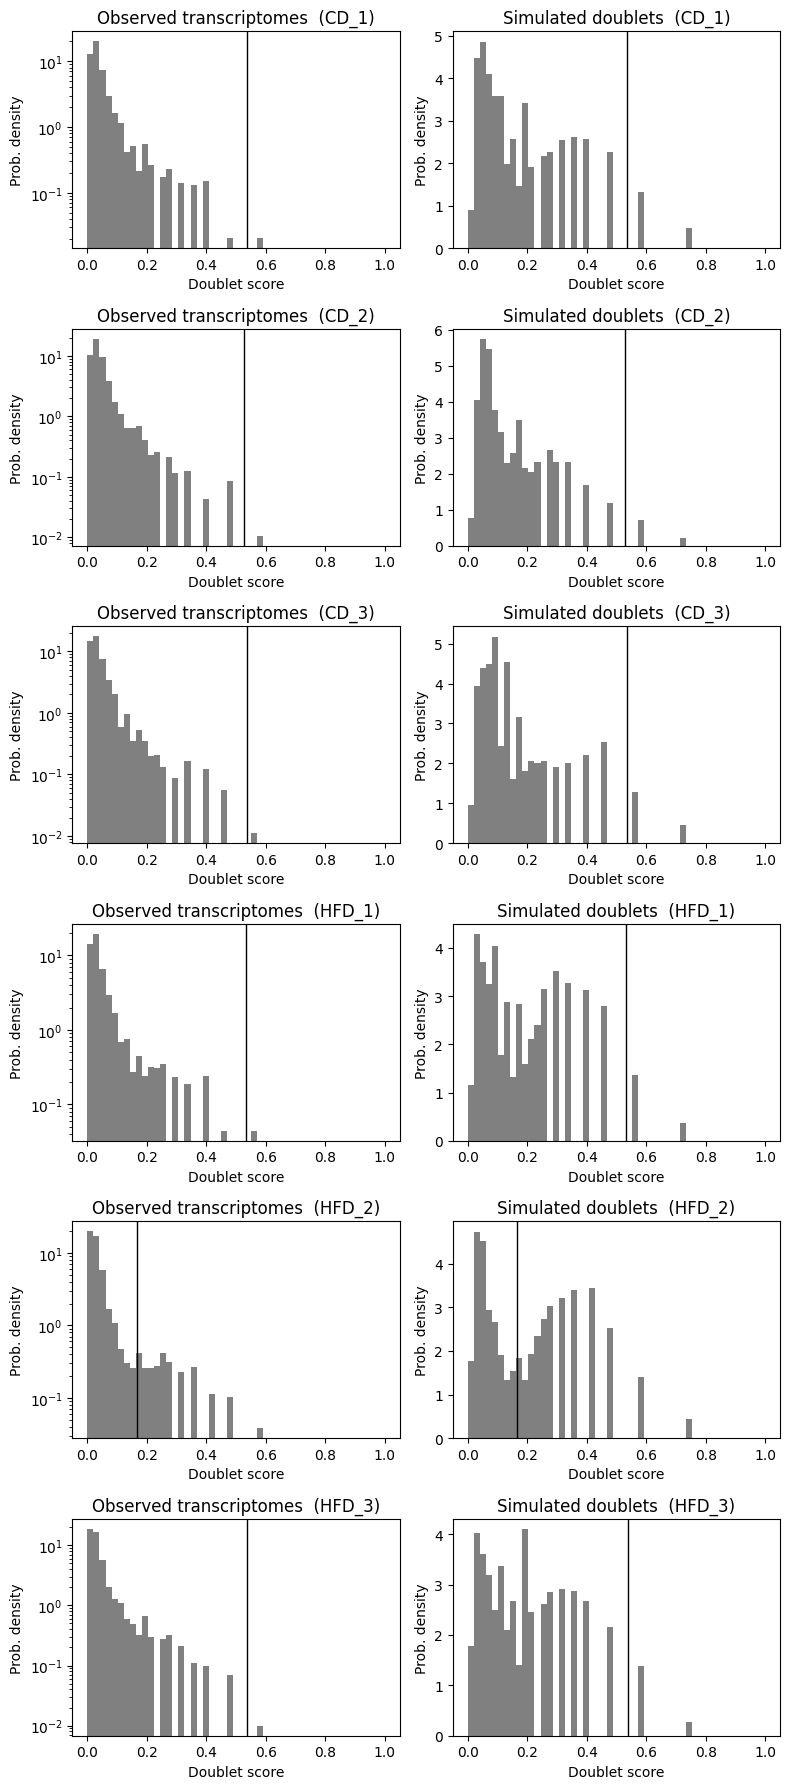

In [15]:
# Doublet score distribution by sample
sc.pl.scrublet_score_distribution(adata)

In [16]:
print('Number of predicted doublets:', adata.obs['predicted_doublet'].sum())

Number of predicted doublets: 272


In [17]:
print('Number of cells:', len(adata.obs))
print('Removing Doublets...')
adata = adata[adata.obs['predicted_doublet'] == False].copy()
print('Number of cells:', len(adata.obs))

Number of cells: 28456
Removing Doublets...
Number of cells: 28184


/tmp/ipykernel_585647/1481142614.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette = adata.uns['Diet_colors'], legend=False)
/tmp/ipykernel_585647/1481142614.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette = adata.uns['Diet_colors'], legend=False)
/tmp/ipykernel_585647/1481142614.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette = adata.uns['Diet_colors'], legend=False)
/tmp/ipykernel_585647/1481142614.py:14: UserWarning: Numpy array is not a

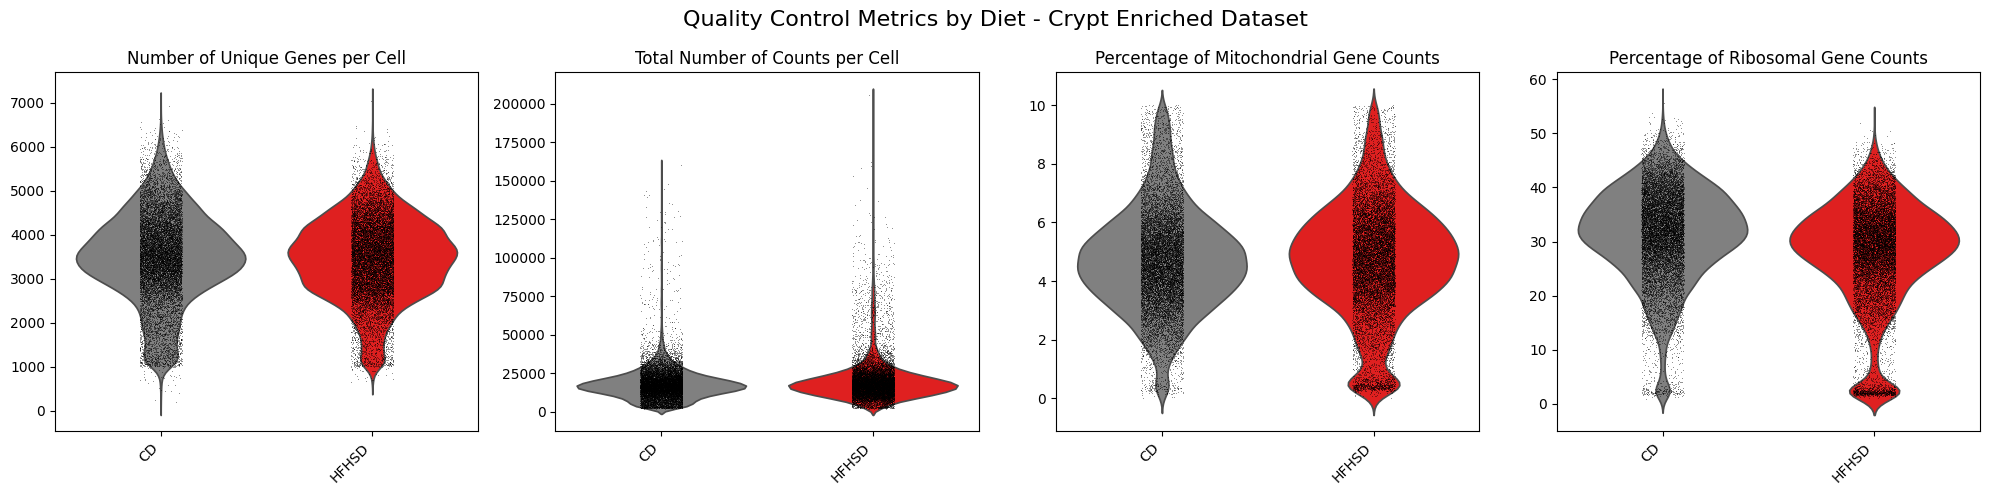

In [18]:
# Plotting violin plots with overlaid scatter plots in one row, grouped by diet
labels = ['Number of Unique Genes per Cell', 'Total Number of Counts per Cell', 'Percentage of Mitochondrial Gene Counts', 'Percentage of Ribosomal Gene Counts']
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Add main title for the whole graph
fig.suptitle('Quality Control Metrics by Diet - Crypt Enriched Dataset', fontsize=16)

for i, (label, key) in enumerate(zip(labels, keys)):
    ax = axes[i]
    
    # Create violin plot, grouped by diet
    sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette = adata.uns['Diet_colors'], legend=False)
    
    # Overlay scatter plot, grouped by diet
    sns.stripplot(data=adata.obs, x='Diet', y=key, ax=ax, size=0.4, jitter=True, dodge=False, legend=False, color='black')
    
    # Customize the plot
    ax.set_title(label)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    # Increase the number of y-axis ticks for the second plot (Total Number of Counts per Cell)
    if i == 1:
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    # Rotate x-axis labels for better readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Normalisation  
**Description:**  
A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [19]:
# Save raw counts for batch effect correction later 
adata.layers["counts"] = adata.X.copy() 

In [20]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw = adata

## Feature selection  
Keep only the top variable genes.  

In [21]:
# n_top_genes = 2000

# # Keep the top n variable genes
# print('Number of genes:', len(adata.var))

# # # Method 1
# # print(f'Selecting top {n_top_genes} variable genes... ⌛')
# # sc.pp.highly_variable_genes(adata, 
# #                             n_top_genes = n_top_genes, 
# #                             batch_key = 'Sample', 
# #                             subset = True, 
# #                             flavor = 'seurat_v3')

# # Method 2
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
# adata = adata[:, adata.var['highly_variable']]

# print('Number of genes:', len(adata.var))

In [22]:
# sc.pl.highly_variable_genes(adata)

## Regress Out Cell Cycle Heterogeneity

In [23]:
s_genes = [x.strip() for x in open('/home/glennrdx/Documents/Research_Project/scRNAseq-MSc-Analysis/upstream_analysis/s_genes_mouse.txt')]
g2m_genes = [x.strip() for x in open('/home/glennrdx/Documents/Research_Project/scRNAseq-MSc-Analysis/upstream_analysis/g2m_genes_mouse.txt')]
cell_cycle_genes = s_genes + g2m_genes

In [24]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


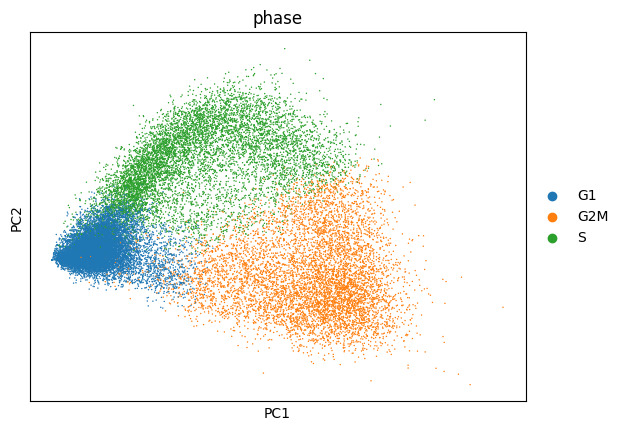

In [25]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [26]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


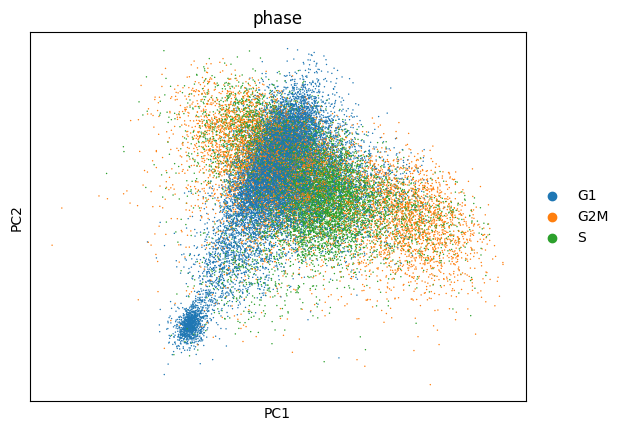

In [ ]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## Dimensionality Reduction  
**Description:**  
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, random_state = 1)

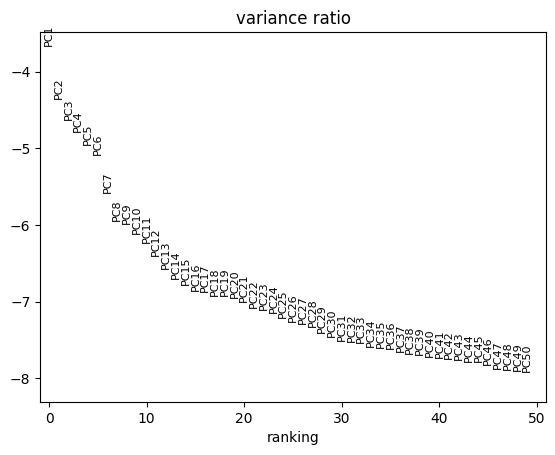

In [ ]:
# Inspect contribution of each individual PC to the total variance in the data.
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

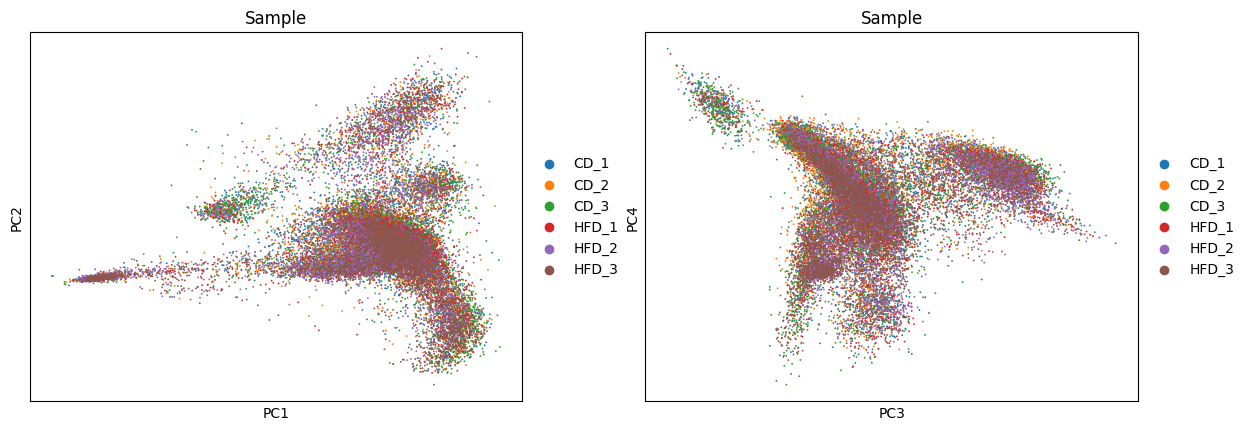

In [ ]:
sc.pl.pca(
    adata,
    color=["Sample", "Sample"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=7,
)

## Nearest neighbor graph constuction and UMAP (Before Batch Correction)

In [ ]:
sc.pp.neighbors(adata, random_state = 1)

In [ ]:
sc.tl.umap(adata, random_state = 1)

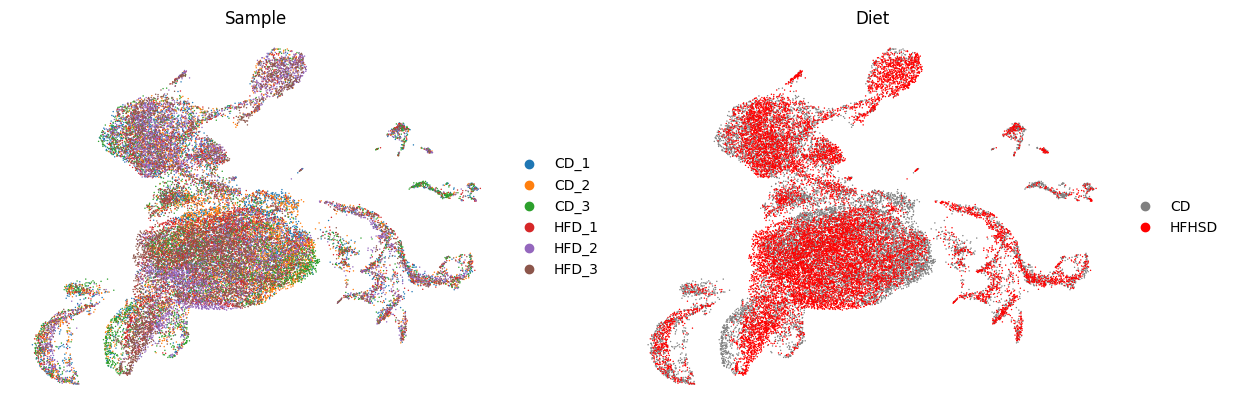

In [ ]:
sc.pl.umap(
    adata,
    color=["Sample", "Diet"],
    ncols=3,
    frameon=False,
)

## Batch Correction

In [34]:
# # Build and train model
# scvi.model.SCVI.setup_anndata(adata, layer = "counts",
#                              categorical_covariate_keys=["Sample"])
# model = scvi.model.SCVI(adata)
# model.train() #may take a while without GPU

In [35]:
# model.save("my_model2/")

In [36]:
# Use trained model to correct the batch error
model = scvi.model.SCVI.load("my_model2/", adata=adata)
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression()

INFO     File my_model2/model.pt already downloaded                                                                


/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case w

## Nearest neighbor graph constuction and UMAP (Batch Corrected)

In [37]:
adata

AnnData object with n_obs × n_vars = 28184 × 17573
    obs: 'Sample', 'Diet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'Diet_colors', 'scrublet', 'log1p', 'pca', 'Sample_colors', 'neighbors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'co

In [38]:
# sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, method='gauss')
sc.pp.neighbors(adata, use_rep = 'X_scVI', random_state = 1)

In [39]:
sc.tl.umap(adata, random_state = 1)

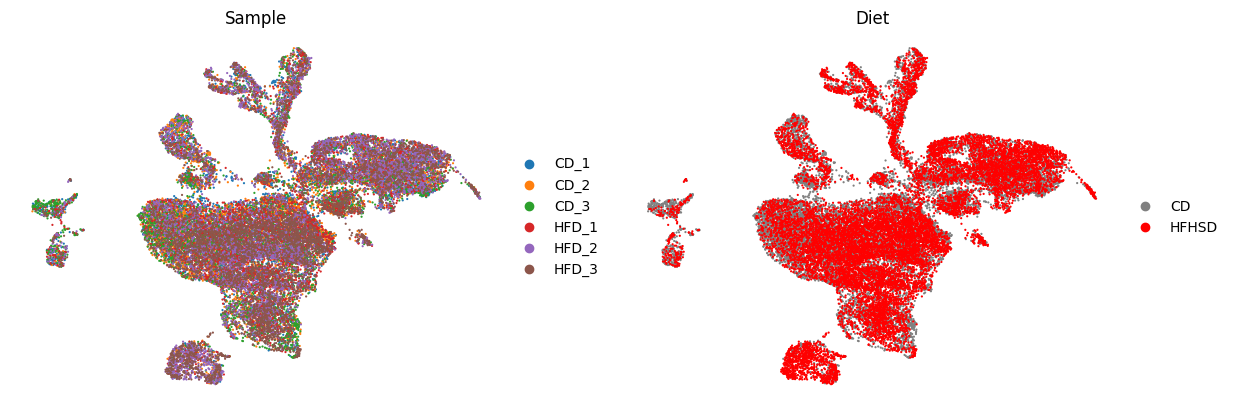

In [40]:
sc.pl.umap(
    adata,
    color=["Sample", "Diet"],
    ncols=3,
    frameon=False,
    size = 10
)

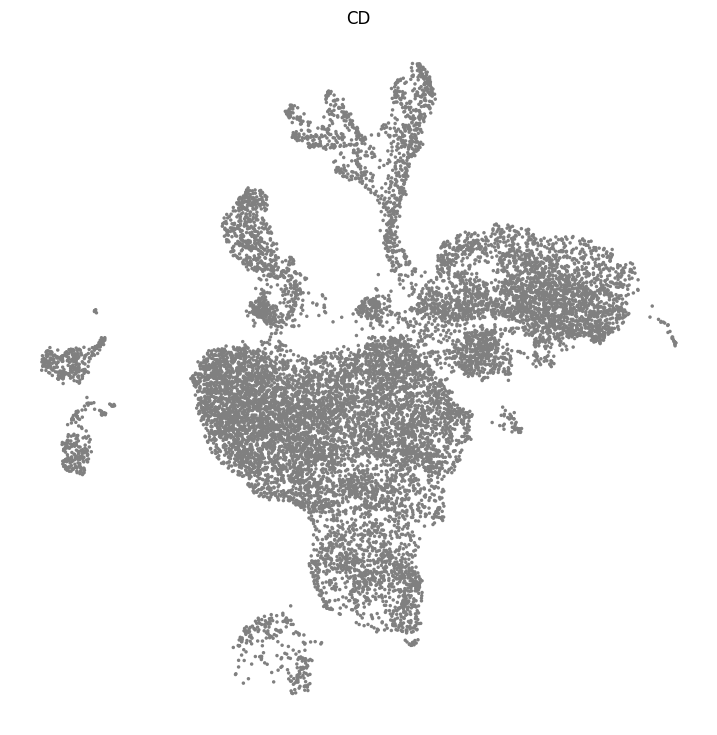

<Figure size 640x480 with 0 Axes>

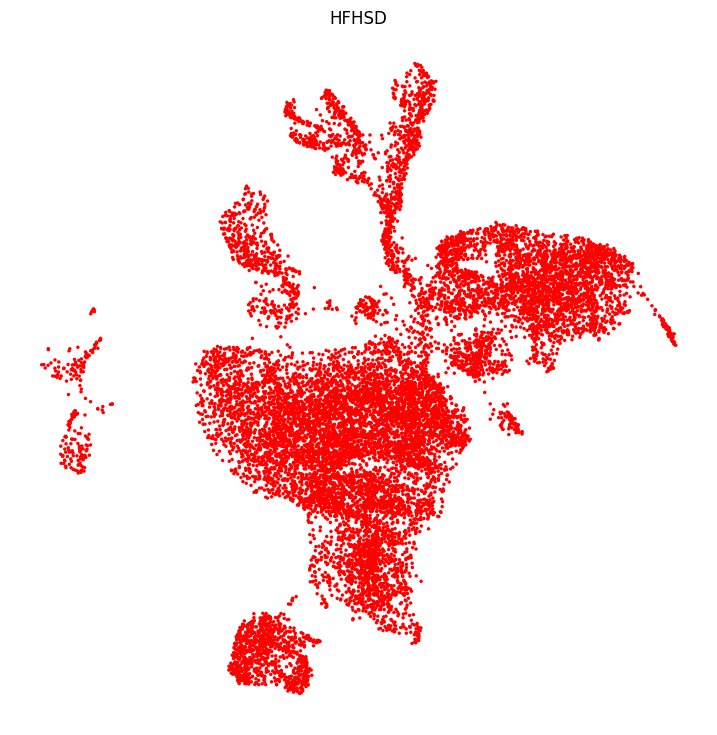

<Figure size 640x480 with 0 Axes>

In [41]:
# CD UMAP
fig, ax = plt.subplots(figsize=(9, 9), facecolor='none', edgecolor='none')
sc.pl.umap(
    adata[adata.obs['Diet'] == 'CD'],
    color=["Diet"],
    frameon=False,
    size=25,
    ax=ax,
    title='CD',
    legend_loc='none'
)
plt.tight_layout()
plt.show()

# HFHSD UMAP
fig, ax = plt.subplots(figsize=(9, 9), facecolor='none', edgecolor='none')
sc.pl.umap(
    adata[adata.obs['Diet'] == 'HFHSD'],
    color=["Diet"],
    frameon=False,
    size=25,
    ax=ax,
    title='HFHSD',
    legend_loc='none'
)
plt.tight_layout()
plt.show()

## Mapping published annotations to my processed data

In [42]:
# adata = sc.read_h5ad('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/data/crypt_processed.h5ad') # unannotated
adata_published = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/published_reference_material/h5ad_files/1_GSE147319_adata_processed.h5ad') #annotations stored in obs. Column name = 'groups _named_prog4'

# Rownames in the obs object are the UMI names in both anndata objects

# Extract the 'obs' data frames
obs_unannotated = adata.obs
obs_annotated = adata_published.obs[['groups_named_prog4']]

# Merge the data frames on the index (UMIs), keeping only common UMIs
merged_obs = obs_unannotated.merge(obs_annotated, left_index=True, right_index=True, how='left')

# Rename the column in the merged DataFrame
merged_obs.rename(columns={'groups_named_prog4': 'published_annotations'}, inplace=True)

# Update the 'obs' attribute of the unannotated AnnData object
adata.obs = merged_obs

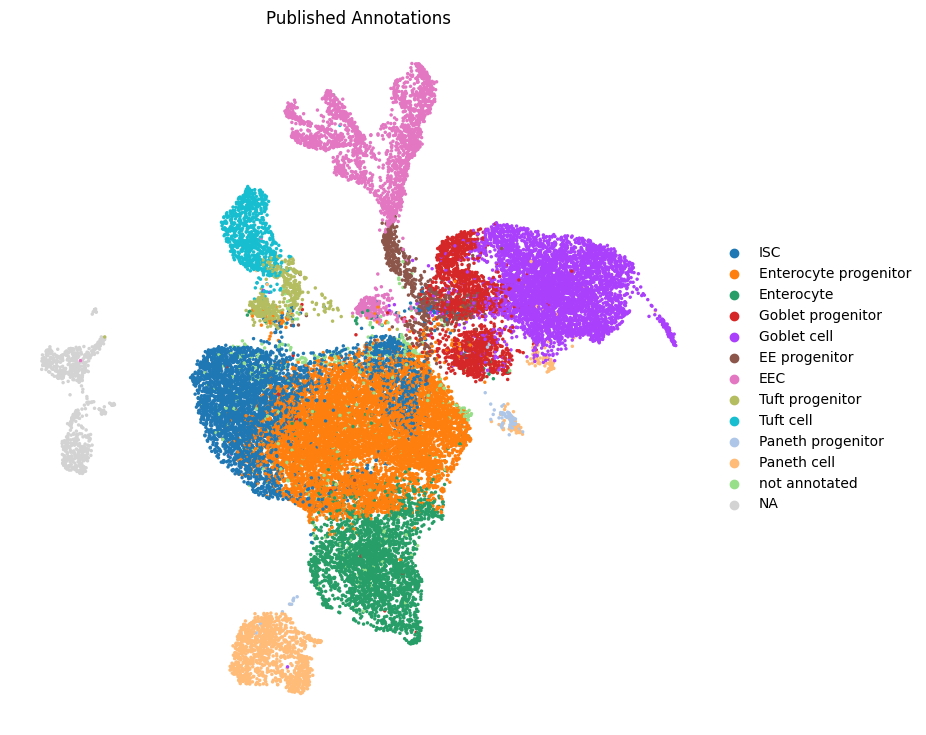

In [43]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["published_annotations"],
    frameon=False,
    size=25,
    ax=ax,
    title = 'Published Annotations'
)

# Show the plot
plt.show()

## Output the data

In [44]:
adata

AnnData object with n_obs × n_vars = 28184 × 17573
    obs: 'Sample', 'Diet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'published_annotations'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'Diet_colors', 'scrublet', 'log1p', 'pca', 'Sample_colors', 'neighbors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'published_annotations_colors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_ca

In [45]:
# Specify the components to keep in .uns
uns_keys_to_keep = [
    'umap', 'Sample_colors', 'Diet_colors', 'final_annotations', 'final_annotations_colors', 
    'published_annotations_colors', 'major_cell_types_colors', 'neighbors'
]

# Create a new dictionary with only the specified keys
adata_uns_filtered = {key: adata.uns[key] for key in uns_keys_to_keep if key in adata.uns}

# Assign the filtered uns dictionary back to adata
adata.uns = adata_uns_filtered
 
# Remove unnecessary layers, obsm, varm, obsp, varp, raw
adata.layers.clear()  # Clear any layers
adata.varm.clear()    # Clear any varm
adata.varp.clear()    # Clear any varp (e.g., pairwise similarities for variables)

# Check if raw data is present and remove it if not needed
if adata.raw is not None:
    del adata.raw

adata

AnnData object with n_obs × n_vars = 28184 × 17573
    obs: 'Sample', 'Diet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'published_annotations'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'umap', 'Sample_colors', 'Diet_colors', 'published_annotations_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs', 'X_scVI'
    obsp: 'distances', 'connectivities

In [46]:
adata.write('/home/glennrdx/Documents/Research_Project/processed_h5ad/crypt_enriched_temp.h5ad')